<a href="https://colab.research.google.com/github/D-314/FoWC/blob/main/Lab_2_FoWC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import cm
from google.colab import files

In [ ]:
def channel_model_3gpp(name):
	if name == 'pedestrian':
		delays = np.array([0, 30, 70, 90, 120, 190, 410]) * 1e-9
		gains_db = np.array([0, -1.0, -2.0, -3.0, -8.0, -17.2, -20.8])
	elif name == 'vehicular':
		delays = np.array([0, 30, 150, 310, 370, 710, 1090, 1730, 2510]) * 1e-9
		gains_db = np.array([0, -1.5, -1.4, -3.6, -0.6, -9.1, -7.0, -12.0, -16.9])
	elif name == 'urban':
		delays = np.array([0, 50, 120, 200, 230, 500, 1600, 2300, 5000]) * 1e-9
		gains_db = np.array([-1.0, -1.0, -1.0, 0.0, 0.0, 0.0, -3.0, -5.0, -7.0])
	else:
		raise TypeError(f'Unknown channel model type: {name}')
	return delays, gains_db
	
class JakesModel:
	def __init__(self, rng, n_sinusoids, f_d):
		# Initial phases
		self.a_m = rng.uniform(0, 2 * np.pi, size=(n_sinusoids, 1))
		self.b_m = rng.uniform(0, 2 * np.pi, size=(n_sinusoids, 1))
		# No line of sight. Uniform angular power distribution
		self.aoa = rng.uniform(0, 2 * np.pi, size=(n_sinusoids, 1))
		self.n_sinusoids = n_sinusoids
		self.f_d = f_d
		
	def get(self, t):
		"""
		Calculate narrowband channel gains given array of time instances
		"""
		# Keep in mind the numpy broadcasting rules!
		# https://numpy.org/doc/stable/user/basics.broadcasting.html
		h_re = np.cos(2 * np.pi * self.f_d * np.cos(self.aoa) * t + self.a_m)
		h_im = np.sin(2 * np.pi * self.f_d * np.cos(self.aoa) * t + self.b_m)
		return np.sum(h_re + 1j * h_im, axis=0) / np.sqrt(self.n_sinusoids)

In [ ]:
Bmax=20e6
c = 299792458
fc = 1.9e9
v = 3.15e3/3600
time_res = 1000 #@param {type:"integer"}
freq_res = 1024 #@param {type:"integer"}
dt = 1e-3
channel_model_name = "pedestrian" #@param ["pedestrian", "vehicular", "urban"]
(delays, gains_db) = channel_model_3gpp(channel_model_name)
gains_lin = np.sqrt(10**(gains_db/10))
L = delays.size
JM = [JakesModel(rng = np.random.default_rng(), n_sinusoids = 1000, f_d = fc*v/c) for _ in range(L)]
t = np.arange (0,1,(1/time_res))
H = np.array([model.get(t) for model in JM])

W = np.linspace(-2*np.pi*Bmax,2*np.pi*Bmax,freq_res)

res = [np.sum(H*gains_lin[:,None]*np.exp(1j*w*delays)[:,None],axis=0) for w in W]
res = 10*np.log10(np.abs(res)**2)

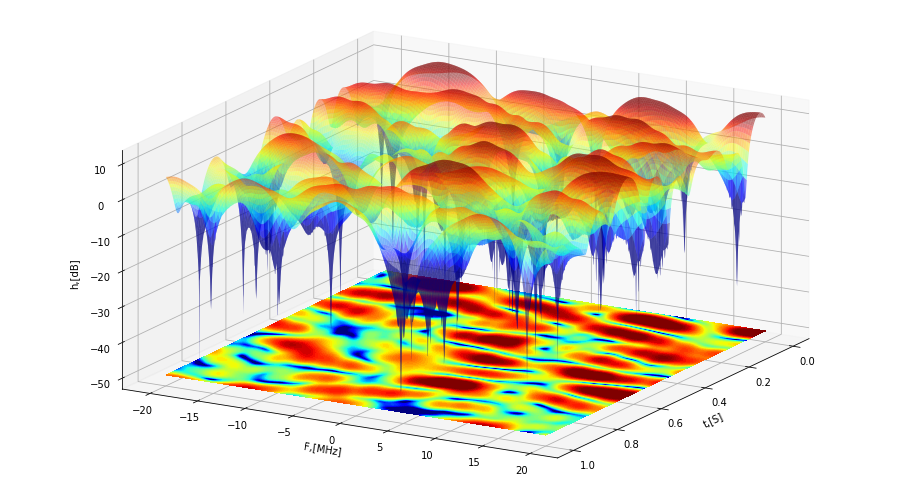

In [ ]:
X,Y = np.meshgrid(t,W/(2e6*np.pi))
fig_height = 16 #@param {type:"integer"}
fig_width = 9 #@param {type:"integer"}

plt.rcParams["figure.figsize"] = (fig_height,fig_width)
ax = plt.axes(projection='3d')
cmap_res = 200 #@param {type:"integer"}
ax.plot_surface(X, Y, res,
                linewidth=0,
                cmap="jet",
                rcount=cmap_res,
                ccount=cmap_res,
                alpha=0.5,
                vmin = -10,
                vmax = 10)

ax.contourf(X, Y, res, 255,
            cmap="jet",
            linestyles="none",
            offset=-50,
            vmin = -10,
            vmax = 10)

ax.set_xlabel('t,[S]')
ax.set_ylabel('F,[MHz]')
ax.set_zlabel('h,[dB]')
ax.set_proj_type('ortho')
azimuth = 30 #@param {type:"slider", min:0, max:360, step:15}
elevation = 30 #@param {type:"slider", min:0, max:360, step:15}
ax.view_init(elevation,azimuth)
download_svg = False #@param {type:"boolean"}
if download_svg:
  imgname = channel_model_name + "_v_{}_fc_{}.svg".format(v*3.6,fc/1e9)
  plt.savefig(imgname)
  files.download(imgname)

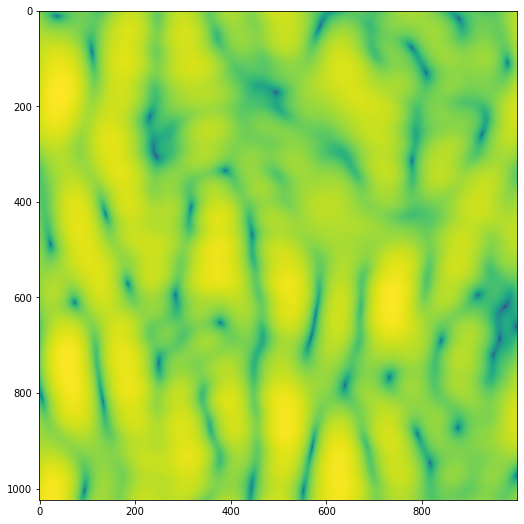

In [ ]:
plt.imshow(np.real(res))